In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm

In [2]:
from IPython.display import Image
%matplotlib inline

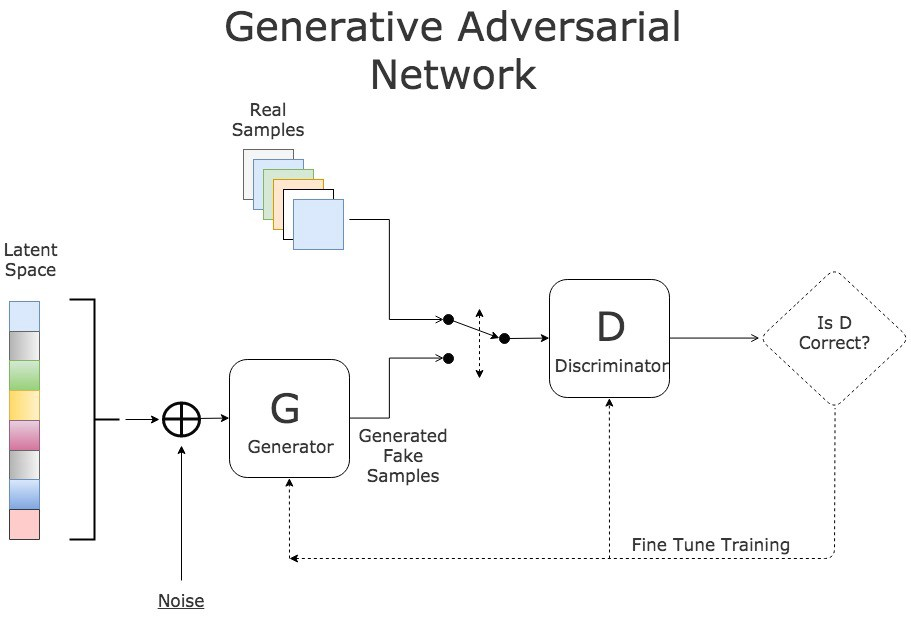

In [4]:
Image(filename='figures/gan.png', width=600)

In [10]:
batch_size=512
epochs=200
sample_size=64
nz=20 #latent_vector_size
k=1 #number of steps to apply to discriminator

In [5]:
print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.13.1
GPU Available: True


In [7]:
#image->tensor
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
#transform tensor into image
to_pil_image=transforms.ToPILImage()

In [9]:
train_data=MNIST(root='../input/data',
                 train=True,
                 download=True,
                 transform=transform)
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/data\MNIST\raw\train-images-idx3-ubyte.gz to ../input/data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/data\MNIST\raw\train-labels-idx1-ubyte.gz to ../input/data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../input/data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../input/data\MNIST\raw



In [12]:
#생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__() #nn.Module의 init function계승
        self.nz=20
        self.out=784
        self.fc1=nn.Sequential(
            nn.Linear(self.nz,256),
            nn.LeakyReLU(0.2)
        )
        self.fc2=nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        self.fc3=nn.Sequential(
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2)
        )
        self.fc4=nn.Sequential(
            nn.Linear(1024,self.out),
            nn.Tanh()
        )
    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)
        x=x.view(-1,1,28,28) #batch_size, channel, height, weight
        return x

In [14]:
#판별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.input=784
        self.out=1
        self.fc1=nn.Sequential(
            nn.Linear(self.input,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2=nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3=nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc4=nn.Sequential(
            nn.Linear(256,self.out),
            nn.Sigmoid()
        )
    def forward(self,x):
        x=x.view(-1,784)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)
        return x

In [15]:
generator=Generator().to(device)
discriminator=Discriminator().to(device)

In [16]:
g_optim=optim.Adam(generator.parameters(),lr=2e-4)
d_optim=optim.Adam(discriminator.parameters(),lr=2e-4)

In [17]:
#그림이 real or fake
criterion=nn.BCELoss()

In [49]:
losses_g=[]
losses_d=[]
images=[]

In [19]:
def label_real(size):
    data=torch.ones(size,1)
    return data.to(device)
def label_fake(size):
    data=torch.zeros(size,1)
    return data.to(device)
def create_noise(sample_size,nz):
    return torch.randn(sample_size,nz).to(device)

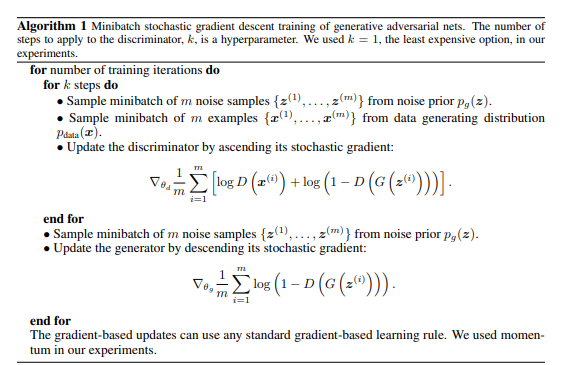

In [20]:
"""
원 논문의 loss 수식과 bceloss를 활용한 logic의 차이점?

손으로 수식 짰을때 완전히 동일
"""
Image(filename='figures/grad.png', width=600)

In [46]:
#판별자 train
def train_discriminator(optimizer,data_real,data_fake):
    n=data_real.size(0)
    
    optimizer.zero_grad()
    
    #real을 real로 판별
    prediction=discriminator(data_real)
    error_real=criterion(prediction,label_real(n))
    error_real.backward()
    
    #fake를 fake로 판별
    predict_fake=discriminator(data_fake)
    error_fake=criterion(predict_fake,label_fake(n))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real+error_fake

In [22]:
def train_generator(optimizer,data_fake):
    n=data_fake.size(0)
    
    optimizer.zero_grad()
    
    #fake를 real로 판별
    prediction=discriminator(data_fake)
    error=criterion(prediction,label_real(n))
    error.backward()
    optimizer.step()
    
    return error

In [23]:
noise=create_noise(sample_size,nz)

In [30]:
#save generated image
def save_img(image,path):
    save_image(image,path)

In [50]:
#train
generator.train()
discriminator.train()
for epoch in range(epochs):
    loss_g=0.0
    loss_d=0.0
    for i,data in enumerate(train_loader):
        image,_=data
        image=image.to(device)
        n=len(image)
        #k번만큼 discriminator실행
        for step in range(k):
            data_fake=generator(create_noise(n,nz)).detach()#detach하는이유 = noise에게 backpropa안가게
            data_real=image
            #train discriminator
            loss_d+=train_discriminator(d_optim,data_real,data_fake)
        data_fake=generator(create_noise(n,nz))
        #train generator
        loss_g+=train_generator(g_optim,data_fake)
        
    generated_img=generator(noise).cpu().detach()
    generated_img=make_grid(generated_img)
    #save image
    save_img(generated_img,f"gen/gen_img{epoch}.png")

    images.append(generated_img)
    epoch_loss_g=loss_g/n
    epoch_loss_d=loss_d/n
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch,epoch_loss_g,epoch_loss_d))
print("done training")
torch.save(generator.state_dict(),'mnist_generator.pth')
#generator만 저장하는 이유 => 추후 이 모델을 쓸때에는 이미지 생성에만 쓰일것이기 때문

Epoch 0: g_loss: 6.66129684 d_loss: 0.44314775
Epoch 1: g_loss: 3.79247928 d_loss: 1.59594727
Epoch 2: g_loss: 7.81973982 d_loss: 0.65441716
Epoch 3: g_loss: 3.44406891 d_loss: 0.90928388
Epoch 4: g_loss: 3.60594344 d_loss: 0.92730522
Epoch 5: g_loss: 2.06932831 d_loss: 1.40363121
Epoch 6: g_loss: 1.70001411 d_loss: 1.38525152
Epoch 7: g_loss: 1.58676267 d_loss: 1.43587041
Epoch 8: g_loss: 2.40574884 d_loss: 1.02856779
Epoch 9: g_loss: 2.87268591 d_loss: 1.12846649
Epoch 10: g_loss: 2.08573532 d_loss: 1.12438846
Epoch 11: g_loss: 2.35336781 d_loss: 0.92619693
Epoch 12: g_loss: 2.45635724 d_loss: 0.86135924
Epoch 13: g_loss: 3.00560045 d_loss: 0.75756001
Epoch 14: g_loss: 3.33992195 d_loss: 0.83081526
Epoch 15: g_loss: 3.13890815 d_loss: 0.62517011
Epoch 16: g_loss: 4.01792812 d_loss: 0.37916815
Epoch 17: g_loss: 4.01083946 d_loss: 0.71501660
Epoch 18: g_loss: 3.90721941 d_loss: 0.64597744
Epoch 19: g_loss: 3.64577103 d_loss: 0.57425761
Epoch 20: g_loss: 3.88853693 d_loss: 0.52474749
Ep

In [51]:
images_gif=[np.array(to_pil_image(img)) for img in images]
imageio.mimsave('generator_images_gif.gif',images_gif)

In [55]:
losses_g

[tensor(6.6613, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.7925, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(7.8197, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4441, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.6059, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.0693, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.7000, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.5868, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.4057, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.8727, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.0857, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.3534, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.4564, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.0056, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3399, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.1389, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.0179, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.0108

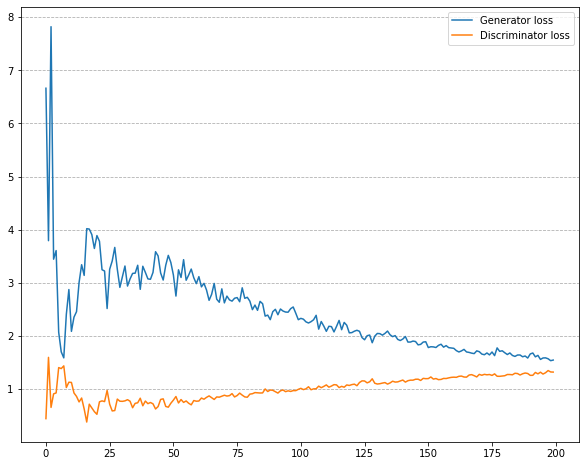

In [66]:
plt.figure(figsize=(10,8))
losses_g_cpu=[t.detach().cpu() for t in losses_g]
losses_d_cpu=[t.detach().cpu() for t in losses_d]
plt.plot(losses_g_cpu,label='Generator loss')
plt.plot(losses_d_cpu,label='Discriminator loss')
plt.grid(True,axis='y',alpha=1,linestyle='--')
plt.legend()
plt.savefig('loss.png')